In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("./data/time_series_60min_singleindex.csv",\
                 usecols=['utc_timestamp', 'DE_load_actual_entsoe_transparency',\
                          'DE_wind_generation_actual', 'DE_solar_generation_actual'])
df["utc_timestamp"] = pd.to_datetime(df["utc_timestamp"])
df['utc_timestamp'] = df["utc_timestamp"].astype('datetime64[ns]')
df = df[(df['utc_timestamp'] < pd.Timestamp(2019, 1, 1)) & (df['utc_timestamp'] >= pd.Timestamp(2018, 1, 1))]
df.reset_index(inplace=True, drop=True)
df.head()

,utc_timestamp,DE_load_actual_entsoe_transparency,DE_solar_generation_actual,DE_wind_generation_actual
0,2018-01-01 00:00:00,40613.0,0.0,33105.0
1,2018-01-01 01:00:00,39713.0,0.0,33868.0
2,2018-01-01 02:00:00,38496.0,0.0,34778.0
3,2018-01-01 03:00:00,38487.0,0.0,34741.0
4,2018-01-01 04:00:00,38750.0,0.0,35345.0


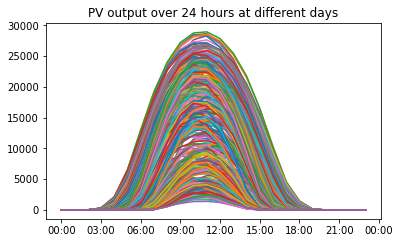

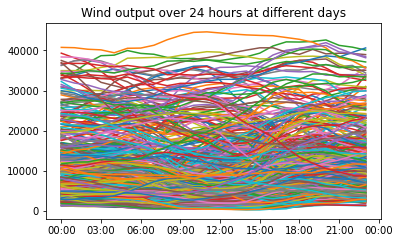

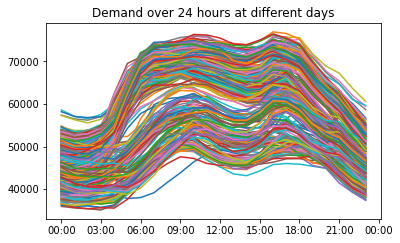

In [3]:
import matplotlib.dates as mdates

myFmt = mdates.DateFormatter('%H:%M')

# solar
plt.gcf().autofmt_xdate()
for i in np.arange(0, len(df), 24):
    fig = plt.plot(df['utc_timestamp'][0:24], df['DE_solar_generation_actual'][i:i+24])
plt.gca().xaxis.set_major_formatter(myFmt)
plt.title('PV output over 24 hours at different days')
plt.show()

# wind
plt.gcf().autofmt_xdate()
for i in np.arange(0, len(df), 24):
    fig = plt.plot(df['utc_timestamp'][0:24], df['DE_wind_generation_actual'][i:i+24])
plt.gca().xaxis.set_major_formatter(myFmt)
plt.title('Wind output over 24 hours at different days')
plt.show()

# demand
plt.gcf().autofmt_xdate()
for i in np.arange(0, len(df), 24):
    fig = plt.plot(df['utc_timestamp'][0:24], df['DE_load_actual_entsoe_transparency'][i:i+24])
plt.gca().xaxis.set_major_formatter(myFmt)
plt.title('Demand over 24 hours at different days')
plt.show()

In [4]:
def create_X(data, N=365):
    X = np.empty((N, 72), dtype=np.float)

    for day in np.arange(N):
        for hour in np.arange(24):
            X[day, hour] = data['DE_wind_generation_actual'][hour + day * 24]
            X[day, hour + 24] = data['DE_solar_generation_actual'][hour + day * 24]
            X[day, hour + 48] = data['DE_load_actual_entsoe_transparency'][hour + day * 24]
    
    return X

In [5]:
X = create_X(df)
X[:, :24]   /= X[:, :24].max()
X[:, 24:48] /= X[:, 24:48].max()
X[:, 48:]   /= X[:, 48:].max()

In [6]:
from src.utils.network import instantiate_network

buses = {
    1 : [True, 0, 1, 0, 0, 400, 'wind', 0.00035, 80],
    2 : [False, 0, 0, 0, 0, 0, None, 0.00035, 240],
    3 : [True, 0, 1, 0, 0, 360, 'solar', 0.00035, 40],
    4 : [False, 0, 0, 0, 0, 0, None, 0.00035, 160],
    5 : [False, 0, 0, 0, 0, 0, None, 0.00035, 240],
    6 : [True, 1, 0, 0.000052, 600, 0, None, 0.00035, 0]
}

lines = {
    (1,2) : [40, 0.4, 100, True, 1, True, 3],
    (1,3) : [38, 0.38, 100, False, 0, True, 3],
    (1,4) : [60, 0.6, 80, True, 1, True, 3],
    (1,5) : [20, 0.2, 100, True, 1, True, 3],
    (1,6) : [68, 0.68, 70, False, 0, True, 3],
    (2,3) : [20, 0.2, 100, True, 1, True, 3],
    (2,4) : [40, 0.4, 100, True, 1, True, 3],
    (2,5) : [31, 0.31, 100, False, 0, True, 3],
    (2,6) : [30, 0.3, 100, False, 0, True, 3],
    (3,4) : [59, 0.59, 82, False, 0, True, 3],
    (3,5) : [20, 0.2, 100, True, 1, True, 3],
    (3,6) : [48, 0.48, 100, False, 0, True, 3],
    (4,5) : [63, 0.63, 75, False, 0, True, 3],
    (4,6) : [30, 0.3, 100, False, 0, True, 3],
    (5,6) : [61, 0.61, 78, False, 0, True, 3]
}

network = instantiate_network(buses, X, lines, 1.0, 6, big_constant=1800, susceptancy_scaling=100)

In [7]:
from src.optimization_models import tep

full_model = tep.two_stage(**network, name="TEP_Garver")
full_model, _ = tep.solve_model(full_model, verbose=True)


--------------------------------------------
--------------------------------------------

Using license file C:\Users\Aiusha\gurobi.lic
Academic license - for non-commercial use only - expires 2021-01-23
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter Method to 2
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter NodeMethod to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter MIPGap to 0.1
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Changed value of parameter Presolve to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 40 physical cores, 80 logical processors, using up to 32 threads
Optimize a model with 665796 rows, 262830 columns and 2006106 nonzeros
Model fingerprint: 0x54aee3aa
Variable types: 262815 continuous, 15 integer (15 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [5e-05, 3e

In [8]:
true_x, true_fmax, true_cost = tep.get_from_model(full_model, len(network['Lines']), network['ExistingLinesNum'])

In [9]:
true_cost

317.416035294628

In [10]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from src.reduction.scenario_reduction import ScenarioReduction
from src.reduction.functional import reduction_analysis

n_scenarios_range = np.arange(1, 11)
models = [KMeans, AgglomerativeClustering, ScenarioReduction]
parameters_dict = {
    'KMeans' : {
        'random_state' : [42]
    },
    'AgglomerativeClustering' : {
        'linkage' : ['ward', 'average', 'single', 'complete']
    },
    'ScenarioReduction' : {
        'method' : ['Dupacova', 'Morales', 'Bruninx']
    }
}
cluster_representations = ['centroid', 'medoid']
n_vars = 25

reduction_results = reduction_analysis(
    "TEP", network, n_scenarios_range, models, parameters_dict, n_vars, None, cluster_representations, scale=True
)

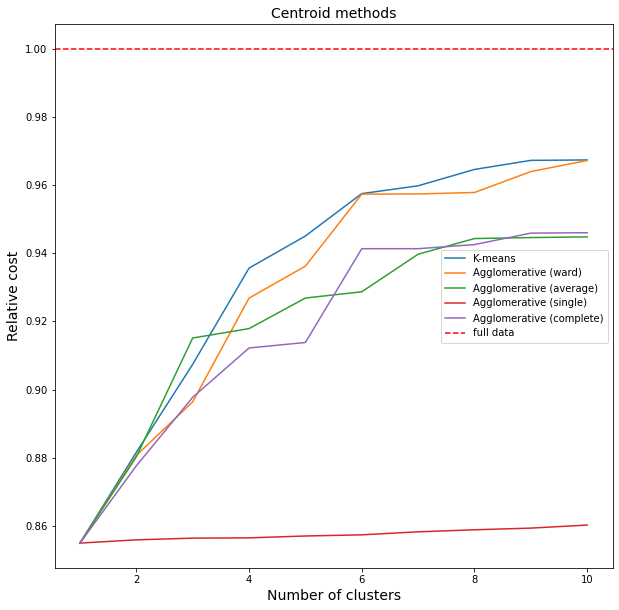

<Figure size 432x288 with 0 Axes>

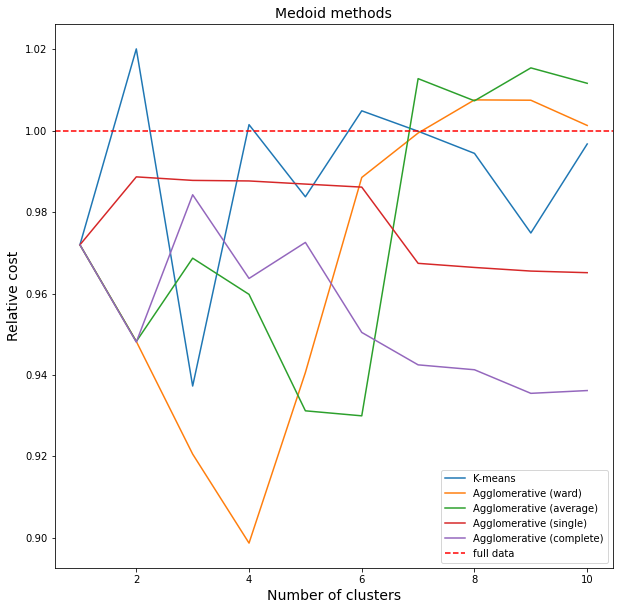

<Figure size 432x288 with 0 Axes>

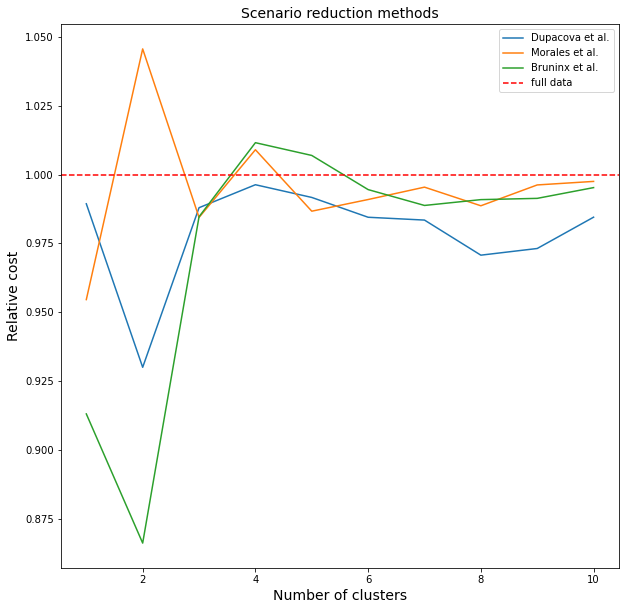

<Figure size 432x288 with 0 Axes>

In [16]:
from src.utils.visualization import cluster_plots

centroid_methods = ['K-means', 'Agglomerative (ward)', 'Agglomerative (average)', 'Agglomerative (single)', 'Agglomerative (complete)']
cluster_plots('centroid', centroid_methods, reduction_results, true_cost, n_scenarios_range, save_name='tep_centroid')
cluster_plots('medoid', centroid_methods, reduction_results, true_cost, n_scenarios_range, save_name='tep_medoid')
sr_methods = ['Dupacova et al.', 'Morales et al.', 'Bruninx et al.']
cluster_plots('sr', sr_methods, reduction_results, true_cost, n_scenarios_range, save_name='tep_sr')

In [12]:
from src.reduction.functional import run_oos_test

oos_results = run_oos_test("TEP", network, reduction_results, 10, 9, 24, name="OSS_TEP_Garver")

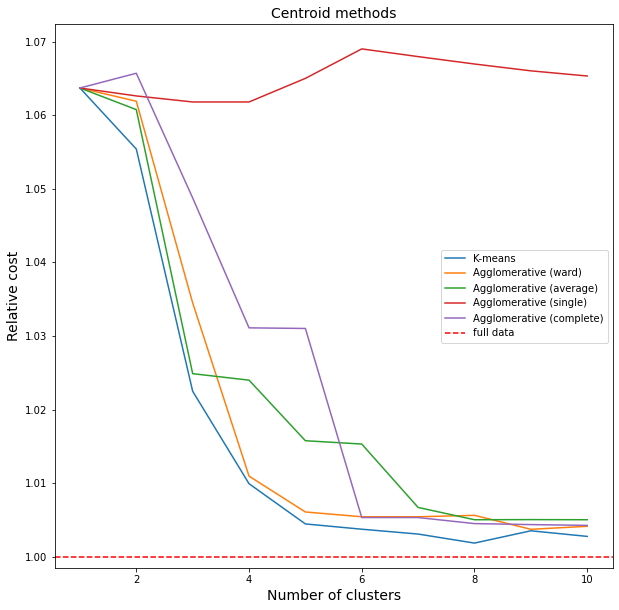

<Figure size 432x288 with 0 Axes>

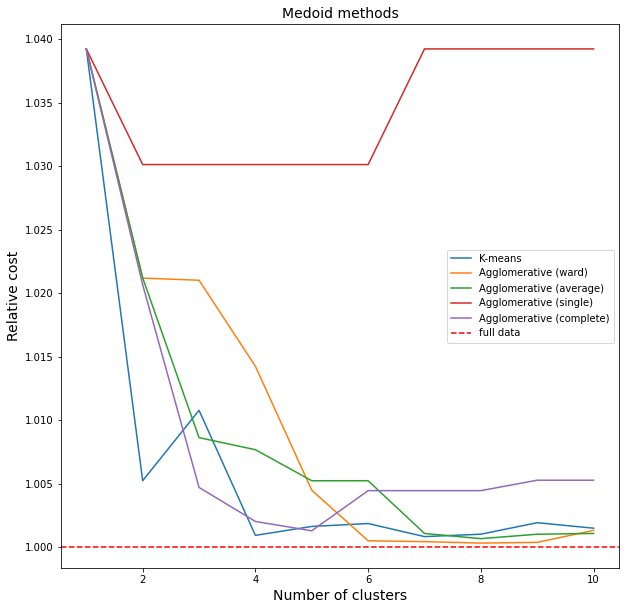

<Figure size 432x288 with 0 Axes>

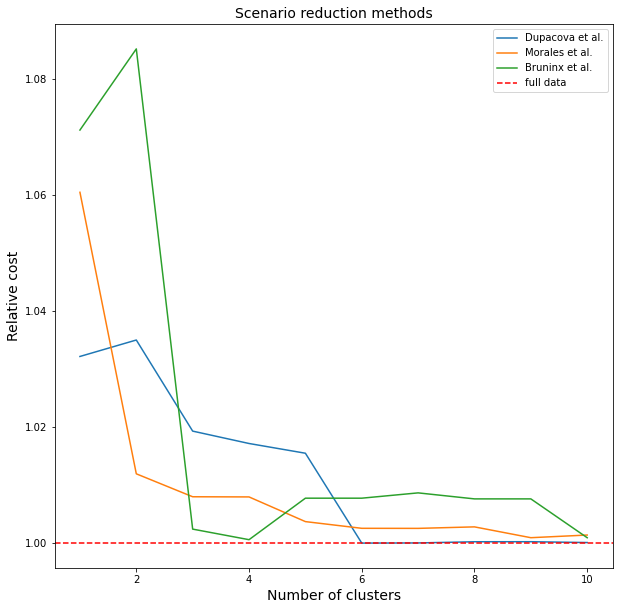

<Figure size 432x288 with 0 Axes>

In [15]:
for method_type in ['centroid', 'medoid', 'sr']:
    oos_results[method_type] = oos_results[method_type][:, :, None]

cluster_plots('centroid', centroid_methods, oos_results, true_cost, n_scenarios_range, cost_location=0, save_name='tep_oos_centroid')
cluster_plots('medoid', centroid_methods, oos_results, true_cost, n_scenarios_range, cost_location=0, save_name='tep_oos_medoid')
cluster_plots('sr', sr_methods, oos_results, true_cost, n_scenarios_range, cost_location=0, save_name='tep_oos_sr')

In [51]:
objective_gaps = {
    "centroid" : (abs(reduction_results['centroid'][:, :, -1] - true_cost) / true_cost).min(axis=1) * 100,
    "medoid" : (abs(reduction_results['medoid'][:, :, -1] - true_cost) / true_cost).min(axis=1) * 100,
    "sr" : (abs(reduction_results['sr'][:, :, -1] - true_cost) / true_cost).min(axis=1) * 100
}

In [25]:
oos_objective_gaps = {
    "centroid" : (abs(oos_results['centroid'][:, :, 0] - true_cost) / true_cost).min(axis=1) * 100,
    "medoid" : (abs(oos_results['medoid'][:, :, 0] - true_cost) / true_cost).min(axis=1) * 100,
    "sr" : (abs(oos_results['sr'][:, :, 0] - true_cost) / true_cost).min(axis=1) * 100
}

In [54]:
oos_objective_gaps

{'centroid': array([0.18576993, 0.37310919, 0.50313005, 6.18062582, 0.42655594]),
 'medoid': array([0.08331774, 0.03223845, 0.06723315, 3.01357348, 0.12913231]),
 'sr': array([0.00605367, 0.09890795, 0.06473149])}

In [27]:
objective_gaps

{'centroid': array([ 3.25901632,  3.27590089,  5.51787038, 13.97651014,  5.39507657]),
 'medoid': array([0.00995599, 0.0532354 , 0.73822106, 1.13081774, 1.57037682]),
 'sr': array([0.36925268, 0.2486269 , 0.47352552])}

In [38]:
gap_table = pd.DataFrame(index=centroid_methods+centroid_methods+sr_methods+['All scenarios'],\
                         columns=['Num repr.', 'Objective value', 'Objective gap', 'Objective OOS', 'Objective OOS gap'])

In [47]:
best_n_cluster_idxs = [9, 9, 9, 9, 9, 6, 6, 7, 1, 2, 3, 9, 9]
reduction_results['centroid'][np.arange(5), best_n_cluster_idxs[:5], -1]

array([307.07139489, 307.01780058, 299.90142991, 273.05235093,
       300.29119716])

In [57]:
best_n_cluster_idxs = [9, 9, 9, 9, 9, 6, 6, 7, 1, 2, 3, 9, 9]
gap_table["Num repr."] = n_scenarios_range[best_n_cluster_idxs].tolist() + [365]
gap_table["Objective value"] = reduction_results['centroid'][np.arange(5), best_n_cluster_idxs[:5], -1].tolist() +\
                               reduction_results['medoid'][np.arange(5), best_n_cluster_idxs[5:10], -1].tolist() +\
                               reduction_results['sr'][np.arange(3), best_n_cluster_idxs[10:], -1].tolist() + [true_cost]
gap_table["Objective gap"] = objective_gaps['centroid'].tolist() + objective_gaps['medoid'].tolist() +\
                             objective_gaps['sr'].tolist() + ['-']
gap_table["Objective OOS gap"] = oos_objective_gaps['centroid'].tolist() + oos_objective_gaps['medoid'].tolist() +\
                                 oos_objective_gaps['sr'].tolist() + ['-']
gap_table["Objective OOS"] = oos_results['centroid'][np.arange(5), best_n_cluster_idxs[:5], 0].tolist() +\
                             oos_results['medoid'][np.arange(5), best_n_cluster_idxs[5:10], 0].tolist() +\
                             oos_results['sr'][np.arange(3), best_n_cluster_idxs[10:], 0].tolist() + [true_cost]

In [58]:
gap_table

,Num repr.,Objective value,Objective gap,Objective OOS,Objective OOS gap
K-means,10,307.071395,3.25902,318.294673,0.18577
Agglomerative (ward),10,307.017801,3.2759,318.729606,0.373109
Agglomerative (average),10,299.901430,5.51787,319.013051,0.50313
Agglomerative (single),10,273.052351,13.9765,338.154510,6.18063
Agglomerative (complete),10,300.291197,5.39508,318.769992,0.426556
K-means,7,317.384433,0.00995599,317.680499,0.0833177
Agglomerative (ward),7,317.247058,0.0532354,317.554282,0.0322385
Agglomerative (average),8,319.759267,0.738221,317.629444,0.0672331
Agglomerative (single),2,313.826638,1.13082,326.981601,3.01357
Agglomerative (complete),3,312.431407,1.57038,318.909989,0.129132
